# Process Gajjar 11A Subbursts

This notebook computes the burst drift for the Gajjar bursts

In [46]:
#!/usr/bin/python3

from __future__ import division
import math
import os
import sys
import time
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
from math import log10
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import pi as nombrepi
from scipy import signal, ndimage
from tqdm import tqdm
from matplotlib import colors as mcolors
import matplotlib as mpl
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd
import corrfns

bursts = pd.read_csv('bursts.csv')


In [2]:
folder = 'data'
outfolder = 'figures'
for burst, filename, edge in tqdm( zip(range(1, len(bursts['filename'])+1), bursts['filename'], bursts['edge']), total=len(bursts['filename']) ):
    if 'gajjar' not in filename:
        continue
    if '11A' not in filename:
        continue
    print('processing {}'.format(filename))
    burst = '11A'

    # junk, nchan, nbin, I, Q, U, V = np.loadtxt('{}/{}'.format(folder, filename), delimiter=' ', unpack=True)
    # Q, U, V = None, None, None
    
    junk, nchan, nbin, I = [], [], [], []
    with open('{}/{}'.format(folder, filename)) as infile:
        for line in infile:
            junki, nchani, nbini, Ii, _, _, _ = line.split(' ')
            junk.append(junki)
            nchan.append(nchani)
            nbin.append(nbini)
            I.append(Ii)
    junk  = np.array(junk, dtype=float)
    nchan = np.array(nchan, dtype=float)
    nbin  = np.array(nbin, dtype=float)
    I     = np.array(I, dtype=float)
    
    n = len(junk)
    print("Data loaded")
    

    binmax = int(nbin[n-1])+1
    frequencymax = (int(nchan[n-1])+1)
    intensity = np.zeros((frequencymax, binmax))

    X = np.zeros(binmax)
    Y = np.zeros(frequencymax)

    # what are these?
    if burst is '11A':
        tmin, tmax = 1, 500
    elif burst is '11D':
        tmin, tmax = 1, 250
    else:
        tmin, tmax = 500, 1500

    #### 1. remove noise
    intensitynoise1 = np.zeros(tmin-1)
    intensitynoise2 = np.zeros(binmax-tmax)
    intensityraw = np.zeros((frequencymax, binmax))
    for i in tqdm(range(frequencymax-50,51,-1), desc='noise removal', disable=True):

        Y[i-1] = 4.15 + (i-1) * 1.5625 # ?

        for j in range(1,tmin) :
            intensitynoise1[j-1] = (I[j-1 + binmax*(frequencymax-i)])/(tmin-1)

        for j in range(tmax+1,binmax+1) :
            intensitynoise2[j-1-tmax] = (I[j-1 + binmax*(frequencymax-i)])/(binmax-tmax)

        a = sum(intensitynoise1)
        b = sum(intensitynoise2)

        for j in range(1,binmax+1) :
            X[j-1] = j-1
            intensity[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)] - 1*(a+b)/2
            intensityraw[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)]

    #### 2. find autocorrelation 
    #burstwindow = intensity[:,edge:edge+frequencymax]
    freqbot = 510
    freqtop = 2200
    if burst is '11A':
        tl, tr = 0, 150
    elif burst is '11D':
        tl, tr = 250, 400
    noise = intensity[freqbot:freqtop,0:40].mean(axis=1)[:, None]
    burstwindow = intensity[freqbot:freqtop,tl:tr] - 1*noise

  0%|          | 0/28 [00:00<?, ?it/s]

processing gajjar/11A_16sec.calib.4p.RM.scr.ASCII
Data loaded


 75%|███████▌  | 21/28 [00:07<00:02,  2.72it/s]

processing gajjar/11A_16sec.calib.4p.RM.scr.ASCII
Data loaded


 86%|████████▌ | 24/28 [00:16<00:04,  1.09s/it]

processing gajjar/11A_16sec.calib.4p.RM.scr.ASCII
Data loaded


 89%|████████▉ | 25/28 [00:23<00:09,  3.12s/it]

processing gajjar/11A_16sec.calib.4p.RM.scr.ASCII
Data loaded


 93%|█████████▎| 26/28 [00:31<00:08,  4.48s/it]

processing gajjar/11A_16sec.calib.4p.RM.scr.ASCII
Data loaded


 96%|█████████▋| 27/28 [00:39<00:05,  5.45s/it]

processing gajjar/11A_16sec.calib.4p.RM.scr.ASCII
Data loaded


100%|██████████| 28/28 [00:46<00:00,  1.67s/it]


[0, 6.1438389934202995, 5.3735351125, 7.84912105]


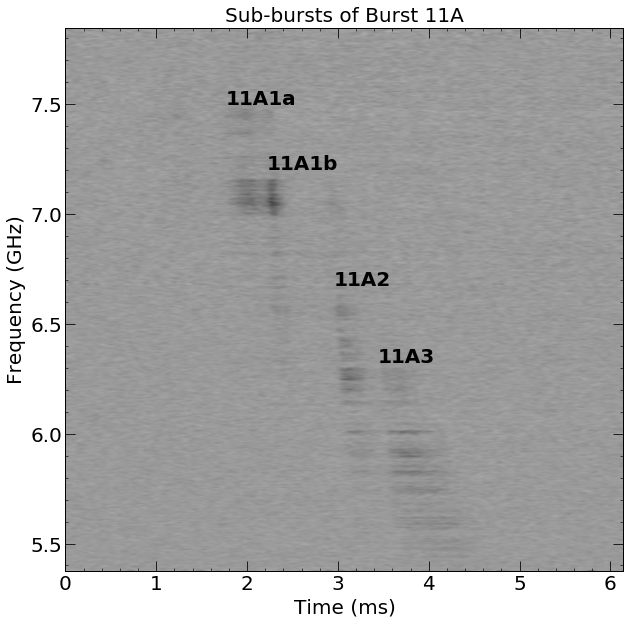

In [122]:
plt.figure(figsize=(10,10))
sub_1  = [41, 68]
sub_1a = [41, 53]
sub_1b = [53, 68]
sub_2  = [69, 83]
sub_3  = [83, 110]
subburst_1 = intensity[freqbot:freqtop, sub_1[0]:sub_1[1]] - 1*noise
subburst_1a = intensity[freqbot:freqtop, sub_1a[0]:sub_1a[1]] - 1*noise
subburst_1b = intensity[freqbot:freqtop, sub_1b[0]:sub_1b[1]] - 1*noise
subburst_2 = intensity[freqbot:freqtop, sub_2[0]:sub_2[1]] - 1*noise
subburst_3 = intensity[freqbot:freqtop, sub_3[0]:sub_3[1]] - 1*noise

chan_width = 1.46484375 # MHz
time_resolution = 4.0958926622802e-5 # seconds
lowestfreq = 6407.7148 - intensity.shape[0]/2*chan_width + chan_width*freqbot # MHz

extents = [0, 
       time_resolution * burstwindow.shape[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
# extents = [0, 1, 0, 1]
print(extents)

### Main Formatting
labelsize = 20
plt.title('Sub-bursts of Burst 11A', size=labelsize)
plt.xlabel('Time (ms)', size=labelsize)
plt.ylabel('Frequency (GHz)', size=labelsize)
plt.tick_params(labelsize=labelsize, direction='in', length=10, top=True, right=True)
plt.tick_params(which='minor', direction='in', top=True, right=True, length=3)
plt.minorticks_on()
plt.imshow(burstwindow, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray_r', extent=extents)

lshift = 1
lsize  = 20
plt.annotate('11A1a', ((sub_1a[0]+lshift+1)*time_resolution*1e3, lowestfreq*1e-3 + chan_width*1e-3*(1450)), weight='bold', size=lsize)
plt.annotate('11A1b', ((sub_1b[0]+lshift)*time_resolution*1e3, lowestfreq*1e-3 + chan_width*1e-3*(1250)), weight='bold', size=lsize)
plt.annotate('11A2', ((sub_2[0]+lshift+2)*time_resolution*1e3, lowestfreq*1e-3 + chan_width*1e-3*(890)), weight='bold', size=lsize)
plt.annotate('11A3', ((sub_3[0]+lshift)*time_resolution*1e3, lowestfreq*1e-3 + chan_width*1e-3*(650)), weight='bold', size=lsize)

# for x in sub_1a: plt.axvline(x=x*time_resolution*1e3, c='w', ls='--', alpha=0.5)
# for x in sub_1b: plt.axvline(x=x*time_resolution*1e3, c='k', ls='--', alpha=0.5)
# for x in sub_2: plt.axvline(x=x*time_resolution*1e3, c='w', ls='--', alpha=0.5)
# for x in sub_3: plt.axvline(x=x*time_resolution*1e3, c='k', ls='--', alpha=0.5)

for f in ['pdf', 'png', 'eps']: plt.savefig('paper_figures/gajjarsubbursts.{}'.format(f))

# chan_width = 1.46484375 # MHz
# lowestfreq = 6407.7148 - intensity.shape[0]/2*chan_width + chan_width*freqbot # MHz
for freqspectrum, c in zip([subburst_1a, subburst_1b, subburst_2, subburst_3], ['y', 'b', 'r', 'k']):
    freqspectrum = pd.DataFrame(freqspectrum[:,:].sum(axis=1)[:, None])
    data = freqspectrum[:][0]
    x = data.keys()
    xo = sum(x*data)/sum(data)
    # plt.axhline(y=xo, c=c)
    # print('weighted center f:', xo*chan_width + lowestfreq, '\tcenter channel:', xo)

In [4]:
print("finding auto-correlations...")

corr = corrfns.auto_corr2D_viafft(burstwindow)
sub1_corr = corrfns.auto_corr2D_viafft(subburst_1)
sub1a_corr = corrfns.auto_corr2D_viafft(subburst_1a)
sub1b_corr = corrfns.auto_corr2D_viafft(subburst_1b)
sub2_corr = corrfns.auto_corr2D_viafft(subburst_2)
sub3_corr = corrfns.auto_corr2D_viafft(subburst_3)

finding auto-correlations...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]


[123124017.01994956,
 64855614.108396925,
 43635738.85276602,
 49526208.55139534,
 50289206.06086472,
 89246623.77567981]

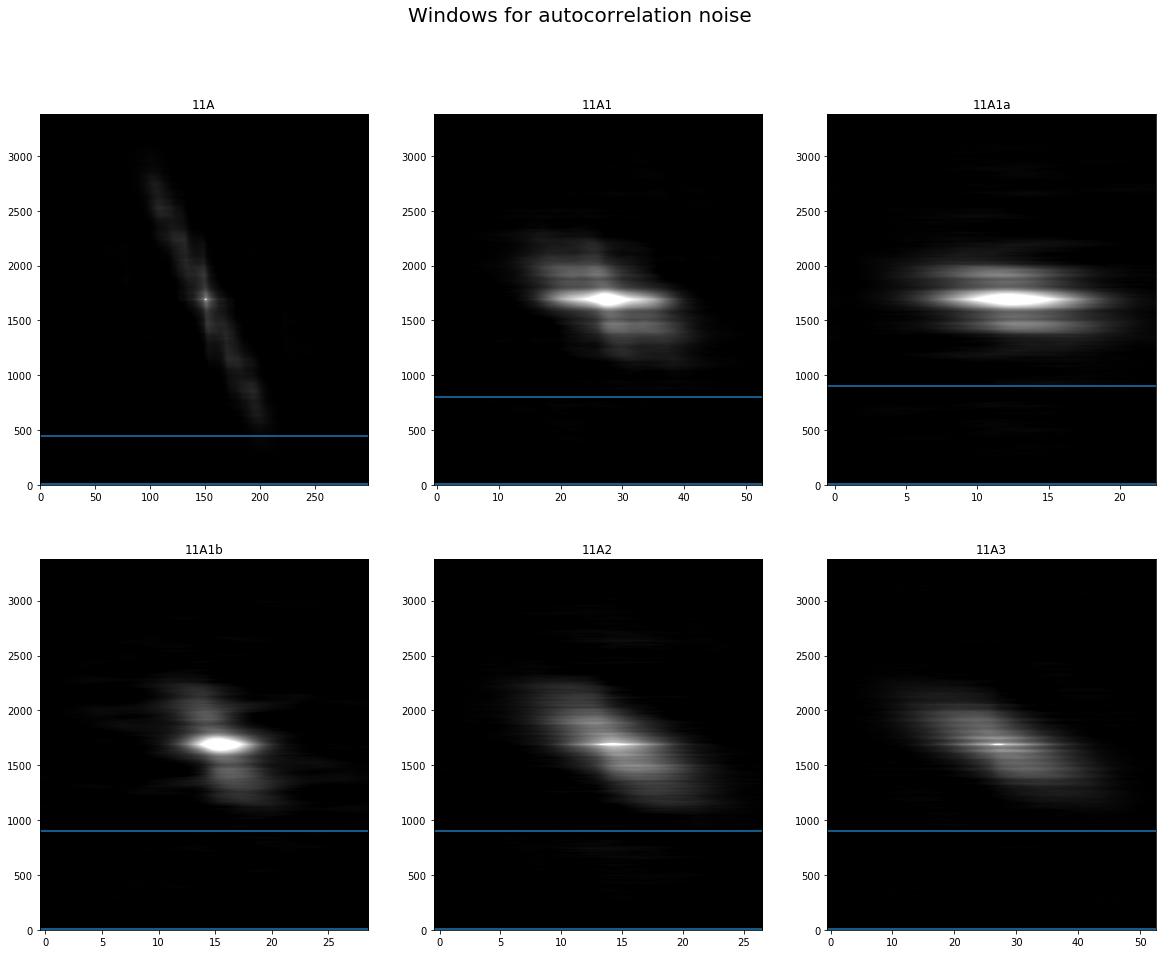

In [82]:
### Autocorrelation Noise
autocorrs = [corr, sub1_corr, sub1a_corr, sub1b_corr, sub2_corr, sub3_corr]
titles = ['11A', '11A1', '11A1a','11A1b','11A2','11A3']
corredges = [(10, 450), (10, 800), (10, 900), (10, 900), (10, 900), (10, 900)]
sigmas = []

plt.figure(figsize=(20, 15))
plt.suptitle('Windows for autocorrelation noise', size=20)
for title, ac, corredge in zip(titles, autocorrs, corredges):
    plt.subplot(2, 3, titles.index(title)+1)
    plt.title(title)
    plt.imshow(ac, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray')
    plt.axhline(y=corredge[0]); plt.axhline(y=corredge[1])
    plt.clim(0, np.max(ac)/8)

    sigmas.append(np.std(ac[corredge[0]:corredge[1]]))

sigmas

In [64]:
#### 3. Fit Gaussian to subburst autocorrelation
# popt, pcov = fitgaussian(corr) #  popt = [amplitude, xo, yo, sigma_x, sigma_y, theta]
# Gaussian 2d Fit Stuff Based on:
# Source: https://gist.github.com/andrewgiessel/6122739
# Source: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m
def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 2.0

def twoD_Gaussian(point, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = point
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = (np.sin(2*theta))/(2*sigma_x**2) - (np.sin(2*theta))/(2*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - a*((x-xo)**2) - b*(x-xo)*(y-yo) - c*((y-yo)**2))
    return g.ravel()

def fitgaussiannlsq(data, p0=[], sigma=0):
    # use curve-fit (non-linear leastsq)
    x, y = np.indices(data.shape)
    # x, y = np.meshgrid(range(0, data.shape[1]), range(0, data.shape[0]))
    p0 = moments(data) if p0 == [] else p0
    sigma = np.zeros(len(data.ravel())) + sigma
    popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x, y), data.ravel(), p0=p0, sigma=sigma, absolute_sigma=True)
    return popt, pcov

#  popt = [amplitude, xo, yo, sigma_x, sigma_y, theta]
popt1, pcov1 = fitgaussiannlsq(sub1_corr, p0=[45839111861.40079, 1600, 26, 500, 5, 0.01], sigma=sigmas[1]) 
popt1a, pcov1a = fitgaussiannlsq(sub1a_corr, p0=[1.2e+08, 1600, 14, 50, 1.1, 0.01], sigma=sigmas[2]) 
popt1b, pcov1b = fitgaussiannlsq(sub1b_corr, p0=[45839111861.40079, 1600, 26, 500, 5, 0.01], sigma=sigmas[3]) 
popt2, pcov2 = fitgaussiannlsq(sub2_corr, p0=[1.00236197e+08, 1.62395947e+03, 2.38934100e+03, 500, 5, 5.185e+03], sigma=sigmas[4]) #  popt = [amplitude, xo, yo, sigma_x, sigma_y, theta]
popt3, pcov3 = fitgaussiannlsq(sub3_corr, p0=[1.17021580e+08, 1.63163916e+03, 3.05914770e+01, 500, 5, 0], sigma=sigmas[5]) #  popt = [amplitude, xo, yo, sigma_x, sigma_y, theta]
perr1 = np.sqrt(np.diag(pcov1))
perr1a = np.sqrt(np.diag(pcov1a))
perr1b = np.sqrt(np.diag(pcov1b))
perr2 = np.sqrt(np.diag(pcov2))
perr3 = np.sqrt(np.diag(pcov3))

for popt, perr in zip([popt1, popt1a, popt1b, popt2, popt3], [perr1, perr1a, perr1b, perr2, perr3]):
    print('solution nlsq:', popt)
    # print('parameter cov:', pcov)
    # print('parameter 1sigma:', perr)


solution nlsq: [ 4.41118620e+09  1.68832551e+03  2.74932338e+01  2.13162008e+02
  5.78687673e+00 -1.59362288e-02]
solution nlsq: [ 2.20718588e+09  1.68906798e+03  1.24887213e+01  1.79245007e+02
  3.43487138e+00 -5.29855314e-03]
solution nlsq: [ 2.70881378e+09  1.68250205e+03  1.54686001e+01  2.07135850e+02
  1.97925684e+00 -4.87455248e-03]
solution nlsq: [1.78069674e+09 1.68308355e+03 1.44886632e+01 2.79354141e+02
 2.74903983e+00 5.18676037e+03]
solution nlsq: [ 2.64730215e+09  1.68899252e+03  2.74973363e+01  2.46998396e+02
  6.09218166e+00 -2.18515460e-02]


In [84]:
### Calculate Chisq
red_chisqs = []
for ac, sigma, popt in zip(autocorrs[1:], sigmas[1:], [popt1, popt1a, popt1b, popt2, popt3]):
    f, t = np.indices(ac.shape)
    fitmap = twoD_Gaussian((f, t), *popt).reshape(ac.shape)
    residuals = ac - fitmap
    chisq = np.sum((residuals / sigma) ** 2)
    red_chisq = chisq / (ac.shape[0]*ac.shape[1] - len(popt)) # chisq/(M-N)
    red_chisqs.append(red_chisq)
    print(chisq, red_chisq)

3508643.679810972 19.59249546189139
917344.4194262996 11.804563310551911
1184566.1040358674 12.089259621736668
430316.3715139666 4.716984790840065
529490.4377066544 2.9567091858245957


In [86]:
### 3.5 Compute drift and error for subbursts
thetas = np.pi/2 - np.array([popt1[-1], popt1a[-1], popt1b[-1], popt2[-1], popt3[-1]])
theta_errs = np.array([perr1[-1], perr1a[-1], perr1b[-1], perr2[-1], perr3[-1]])
sigmax_errors = np.array([perr1[3], perr1a[3], perr1b[3], perr2[3], perr3[3]])
sigmay_errors = np.array([perr1[4], perr1a[4], perr1b[4], perr2[4], perr3[4]])
slopes = np.tan(thetas)

chan_width = 1.46484375 # MHz
time_resolution = 4.0958926622802e-5 # seconds
conversion = chan_width / (time_resolution*1e3)
drifts = conversion * slopes # MHz/ms
drift_errors = conversion * (theta_errs * (1/np.cos(thetas))**2)

driftresults = pd.DataFrame({
    'angle': [popt1[-1], popt1a[-1], popt1b[-1], popt2[-1], popt3[-1]],
    'theta': thetas,
    'slope': slopes,
    'drift(MHz/ms)': drifts,
    'drift error': drift_errors,
    'sigmax_error': sigmax_errors,
    'sigmay_error': sigmay_errors,
    'angle_error': theta_errs,
    'red_chisq'  : red_chisqs
}, index=['1','1a','1b','2','3'])

driftresults

,angle,theta,slope,drift(MHz/ms),drift error,sigmax_error,sigmay_error,angle_error,red_chisq
1,-0.015936,1.586733,-62.744791,-2243.987383,1.807412,0.071194,0.001933,0.000013,19.592495
1a,-0.005299,1.576095,-188.729001,-6749.651926,21.967232,0.113954,0.002188,0.000017,11.804563
1b,-0.004875,1.575671,-205.145413,-7336.763933,14.656192,0.149227,0.001426,0.000010,12.089260
2,5186.760370,-5185.189574,-109.874274,-3929.513225,4.889863,0.227143,0.002236,0.000011,4.716985
3,-0.021852,1.592648,-45.756068,-1636.407401,1.813690,0.171305,0.004226,0.000024,2.956709


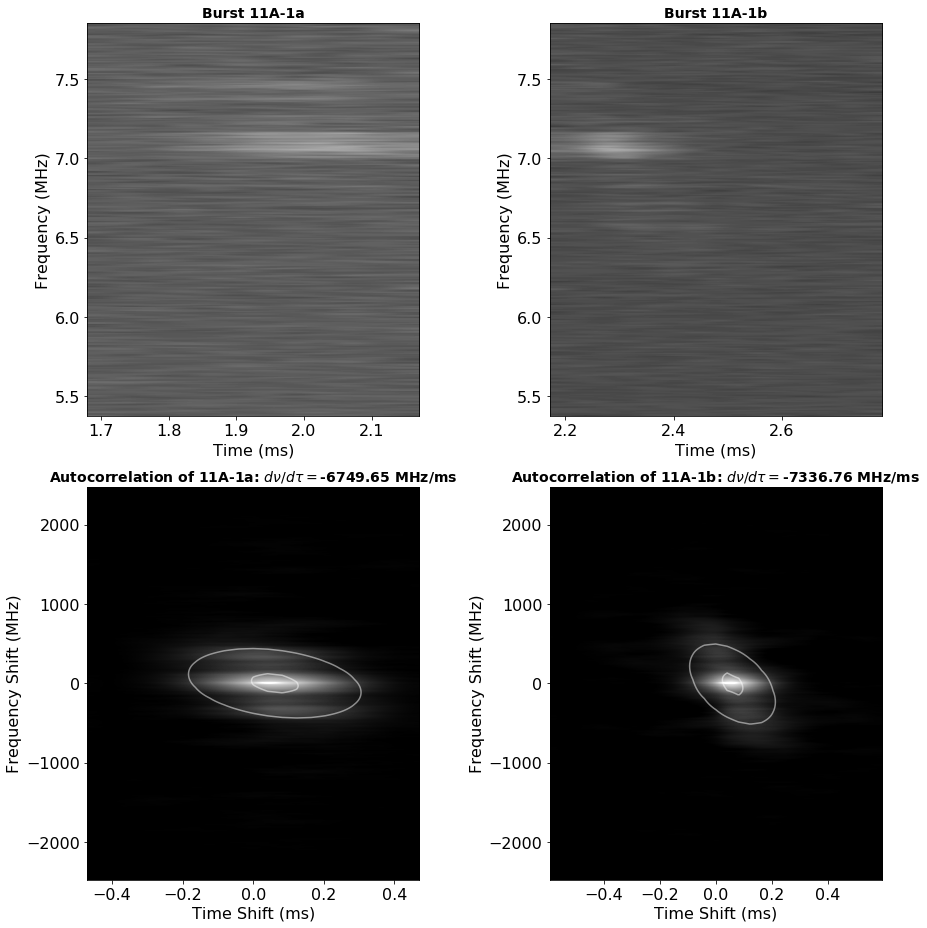

In [66]:
labelsize = 16
ticksize = 16
titlesize = 14

chan_width = 1.46484375 # MHz
time_resolution = 4.0958926622802e-5 # seconds
lowestfreq = 6407.7148 - intensity.shape[0]/2*chan_width + chan_width*freqbot # MHz

extents1a = [time_resolution * sub_1a[0] * 1e3, 
       time_resolution * sub_1a[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
extents1a = [time_resolution * sub_1a[0] * 1e3, 
       time_resolution * sub_1a[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
extents1b = [time_resolution * sub_1b[0] * 1e3, 
       time_resolution * sub_1b[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]


corrextents1a = [-time_resolution * (sub1a_corr.shape[1]/2) * 1e3, 
       time_resolution * (sub1a_corr.shape[1]/2) * 1e3 , 
       - (extents1a[3] - extents1a[2])*1e3, 
        (extents1a[3] - extents1a[2])*1e3]
corrextents1b = [-time_resolution * (sub1b_corr.shape[1]/2) * 1e3, 
       time_resolution * (sub1b_corr.shape[1]/2) * 1e3 , 
       - (extents1a[3] - extents1a[2])*1e3, 
        (extents1a[3] - extents1a[2])*1e3]

plt.figure(figsize=(13, 13))
plt.subplot(221)
plt.title('Burst 11A-1a', size=titlesize, weight='bold')
plt.imshow(subburst_1a, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=extents1a)
plt.ylabel("Frequency (MHz)", size=labelsize)
plt.xlabel("Time (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.subplot(222)
plt.title('Burst 11A-1b', size=titlesize, weight='bold')
plt.imshow(subburst_1b, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=extents1b)
plt.ylabel("Frequency (MHz)", size=labelsize)
plt.xlabel("Time (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.subplot(223)
plt.title('Autocorrelation of 11A-1a: $d\\nu/d\\tau = ${:.2f} MHz/ms'.format(drifts[1]), size=titlesize, weight='bold')
f, t = np.indices(sub1a_corr.shape)
fitmap = twoD_Gaussian((f, t), *popt1a).reshape(sub1a_corr.shape)
plt.imshow(sub1a_corr, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=corrextents1a)
plt.clim(0, np.max(sub1a_corr)/5)
plt.ylabel("Frequency Shift (MHz)", size=labelsize)
plt.xlabel("Time Shift (ms)", size=labelsize)
plt.contour(fitmap, [popt1a[0]/4, popt1a[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents1a)
plt.tick_params(labelsize=ticksize)

plt.subplot(224)
plt.title('Autocorrelation of 11A-1b: $d\\nu/d\\tau = ${:.2f} MHz/ms'.format(drifts[2]), size=titlesize, weight='bold')
f, t = np.indices(sub1b_corr.shape)
fitmap = twoD_Gaussian((f, t), *popt1b).reshape(sub1b_corr.shape)
plt.imshow(sub1b_corr, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=corrextents1b)
plt.clim(0, np.max(sub1b_corr)/5)
plt.contour(fitmap, [popt1b[0]/4, popt1b[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents1b)
plt.ylabel("Frequency Shift (MHz)", size=labelsize)
plt.xlabel("Time Shift (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.tight_layout()
# plt.savefig('11A1subbursts_process.png')

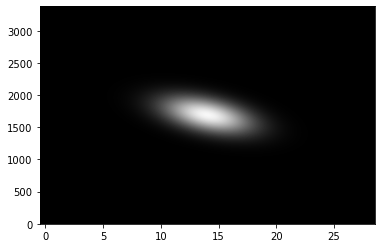

In [236]:
f, t = np.indices(sub1b_corr.shape)
testopts = np.array([2.91200986e+09, 1.68900000e+03, 1.40000000e+01, 1.94919922e+02, 2.27518615e+00, -0.006])
fitmap = twoD_Gaussian((f, t), *testopts).reshape(sub1b_corr.shape)
plt.imshow(fitmap, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray')

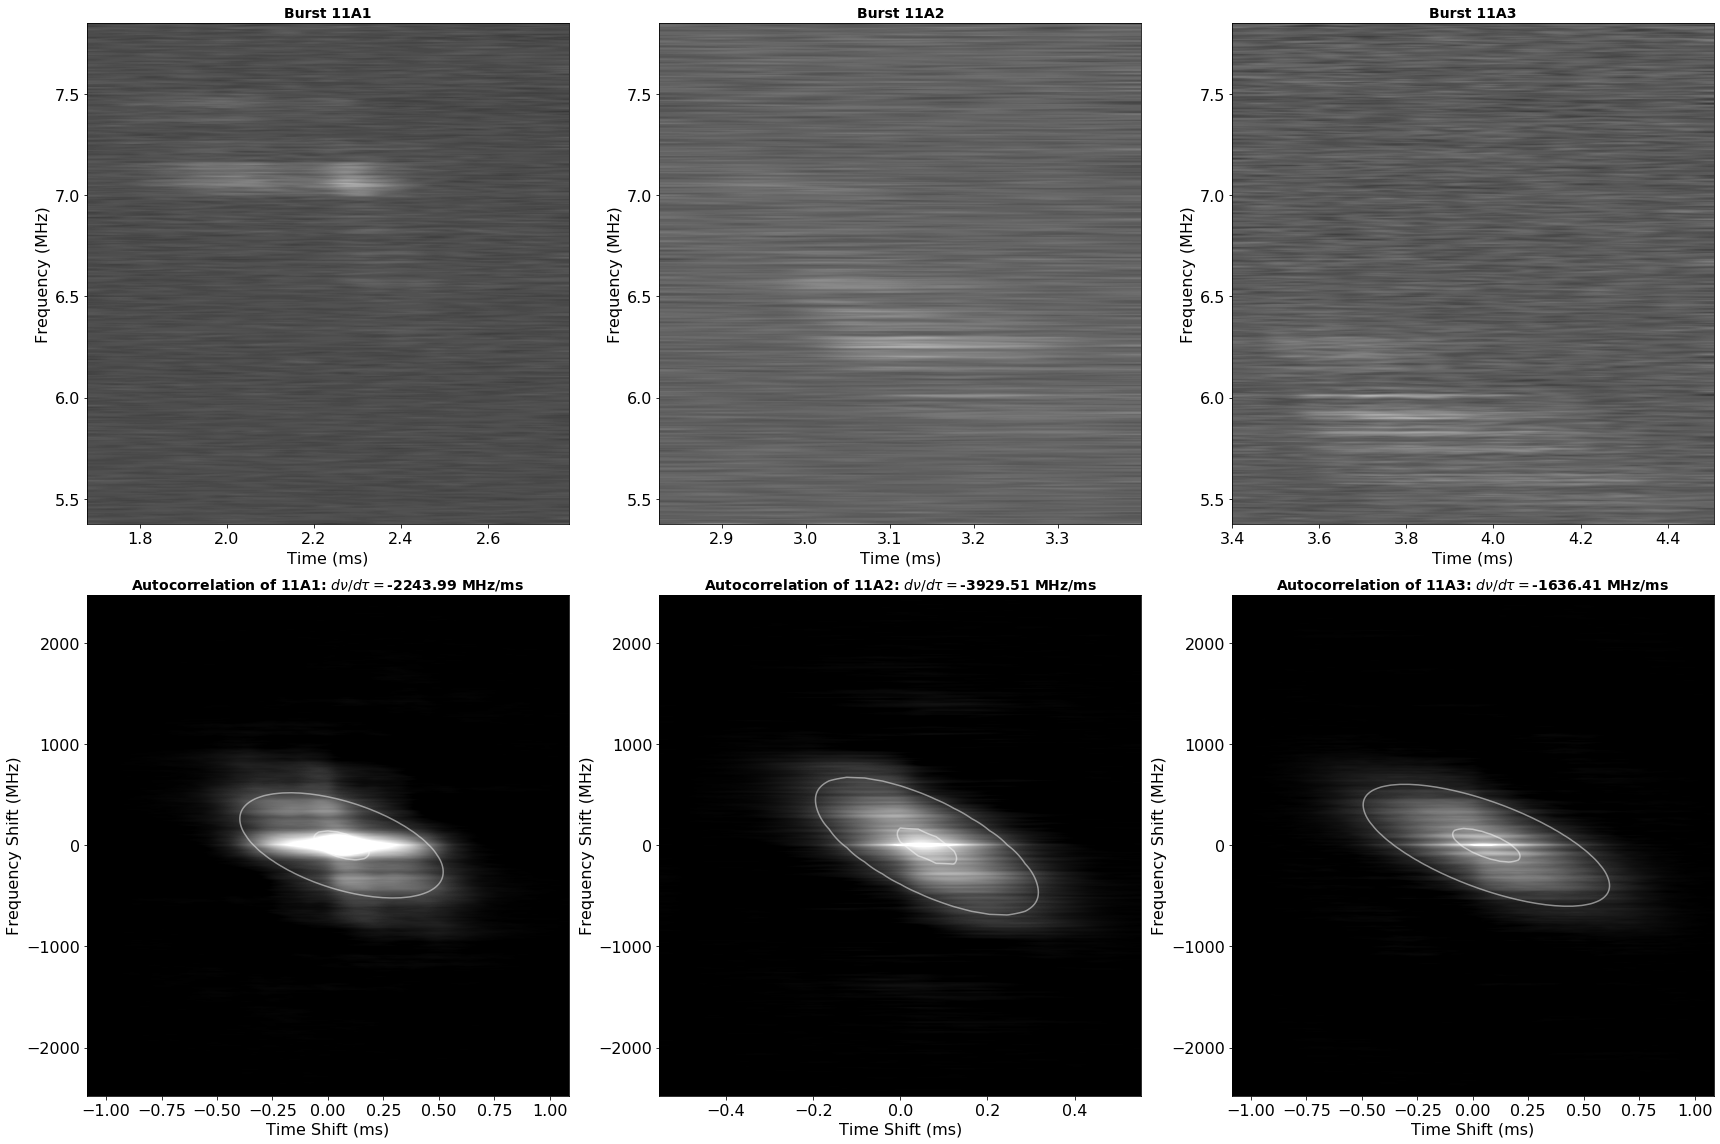

In [62]:
extents1 = [time_resolution * sub_1[0] * 1e3, 
       time_resolution * sub_1[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
extents2 = [time_resolution * sub_2[0] * 1e3, 
       time_resolution * sub_2[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
extents3 = [time_resolution * sub_3[0] * 1e3, 
       time_resolution * sub_3[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]

corrextents1 = [-time_resolution * (sub1_corr.shape[1]/2) * 1e3, 
       time_resolution * (sub1_corr.shape[1]/2) * 1e3 , 
       - (extents1[3] - extents1[2])*1e3, 
        (extents1[3] - extents1[2])*1e3]
corrextents2 = [-time_resolution * (sub2_corr.shape[1]/2) * 1e3, 
       time_resolution * (sub2_corr.shape[1]/2) * 1e3 , 
       - (extents1[3] - extents1[2])*1e3, 
        (extents1[3] - extents1[2])*1e3]
corrextents3 = [-time_resolution * (sub3_corr.shape[1]/2) * 1e3, 
       time_resolution * (sub3_corr.shape[1]/2) * 1e3 , 
       - (extents1[3] - extents1[2])*1e3, 
        (extents1[3] - extents1[2])*1e3]

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Burst 11A1', size=titlesize, weight='bold')
plt.imshow(subburst_1, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=extents1)
plt.ylabel("Frequency (MHz)", size=labelsize)
plt.xlabel("Time (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.subplot(232)
plt.title('Burst 11A2', size=titlesize, weight='bold')
plt.imshow(subburst_2, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=extents2)
plt.ylabel("Frequency (MHz)", size=labelsize)
plt.xlabel("Time (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.subplot(233)
plt.title('Burst 11A3', size=titlesize, weight='bold')
plt.imshow(subburst_3, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=extents3)
plt.ylabel("Frequency (MHz)", size=labelsize)
plt.xlabel("Time (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.subplot(234)
plt.title('Autocorrelation of 11A1: $d\\nu/d\\tau = ${:.2f} MHz/ms'.format(drifts[0]), size=titlesize, weight='bold')
f, t = np.indices(sub1_corr.shape)
fitmap = twoD_Gaussian((f, t), *popt1).reshape(sub1_corr.shape)
plt.imshow(sub1_corr, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=corrextents1)
plt.clim(0, np.max(sub1_corr)/10)
plt.contour(fitmap, [popt1[0]/4, popt1[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents1)
plt.ylabel("Frequency Shift (MHz)", size=labelsize)
plt.xlabel("Time Shift (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)


plt.subplot(235)
plt.title('Autocorrelation of 11A2: $d\\nu/d\\tau = ${:.2f} MHz/ms'.format(drifts[3]), size=titlesize, weight='bold')
f, t = np.indices(sub2_corr.shape)
fitmap = twoD_Gaussian((f, t), *popt2).reshape(sub2_corr.shape)
plt.imshow(sub2_corr, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=corrextents2)
plt.clim(0, np.max(sub2_corr)/10)
plt.contour(fitmap, [popt2[0]/4, popt2[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents2)
plt.ylabel("Frequency Shift (MHz)", size=labelsize)
plt.xlabel("Time Shift (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.subplot(236)
plt.title('Autocorrelation of 11A3: $d\\nu/d\\tau = ${:.2f} MHz/ms'.format(drifts[4]), size=titlesize, weight='bold')
f, t = np.indices(sub3_corr.shape)
fitmap = twoD_Gaussian((f, t), *popt3).reshape(sub3_corr.shape)
plt.imshow(sub3_corr, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=corrextents3)
plt.clim(0, np.max(sub3_corr)/10)
plt.contour(fitmap, [popt3[0]/4, popt3[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents3)
plt.ylabel("Frequency Shift (MHz)", size=labelsize)
plt.xlabel("Time Shift (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.tight_layout()
# plt.savefig('11Asubbursts_process.png')

In [63]:
solverdata = pd.DataFrame({
    '1': popt1,
    '1a': popt1a,
    '1b': popt1b,
    '2': popt2,
    '3': popt3,
}, index=['amplitude', 'xo', 'yo', 'sigma_x', 'sigma_y', 'angle'])
solverdata

,1,1a,1b,2,3
amplitude,4.411186e+09,2.207186e+09,2.708814e+09,1.780697e+09,2.647302e+09
xo,1.688326e+03,1.689068e+03,1.682502e+03,1.683084e+03,1.688993e+03
yo,2.749323e+01,1.248872e+01,1.546860e+01,1.448866e+01,2.749734e+01
sigma_x,2.131620e+02,1.792450e+02,2.071358e+02,2.793541e+02,2.469984e+02
sigma_y,5.786877e+00,3.434871e+00,1.979257e+00,2.749040e+00,6.092182e+00
angle,-1.593623e-02,-5.298553e-03,-4.874552e-03,5.186760e+03,-2.185155e-02


In [86]:
    #### 3. Fit Gaussian to autocorrelation
    print(corr.shape)
    # popt, pcov = fitgaussian(corr) #  popt = [amplitude, xo, yo, sigma_x, sigma_y, theta]

    popt, pcov = fitgaussiannlsq(corr) #  popt = [amplitude, xo, yo, sigma_x, sigma_y, theta]
    perr = np.sqrt(np.diag(pcov))

    print('solution nlsq:', popt)
    # print('parameter cov:', pcov)
    print('parameter 1sigma:', perr)
    

(3379, 299)
solution nlsq: [ 1.23781944e+10  1.68900000e+03  1.49000000e+02 -8.92219645e+00
 -2.48308647e+02  4.69102087e+00]
parameter 1sigma: [9.50310829e+06 1.90575194e-01 7.96768934e-03 6.84963653e-03
 1.90618654e-01 3.90638258e-05]


In [87]:
    f, t = np.indices(corr.shape)
    fitmap2 = twoD_Gaussian((f, t), *popt).reshape(corr.shape)
    print(fitmap2.shape, corr.shape, f.shape, t.shape)
    ### 3.5 Compute drift and error
    chan_width = 1.46484375 # MHz
    time_resolution = 4.0958926622802e-5 # seconds
    # theta = popt[-1] if abs(popt[3]) > abs(popt[4]) else popt[-1] - np.pi/2
    theta = 2*np.pi - popt[-1] # for 11D: solver finds angle CW from pos x axis
    
    slope = np.tan(theta)
    print('solver angle:', popt[-1], 'pos angle:', theta)
    conversion = chan_width / (time_resolution*1e3)
    drift = conversion * slope # MHz/ms
    drift_error = conversion * (perr[-1] * (1/np.cos(theta))**2)
    print('drift error:', drift_error)
    

(3379, 299) (3379, 299) (3379, 299) (3379, 299)
solver angle: 4.691020869770773 pos angle: 1.5921644374088135
drift error: 3.060210943880641


theta 1.5921644374088135
[-6.123359530108899, 6.123359530108899, -2475.5859375, 2475.5859375]
saved figures/burst_11D_figure.png


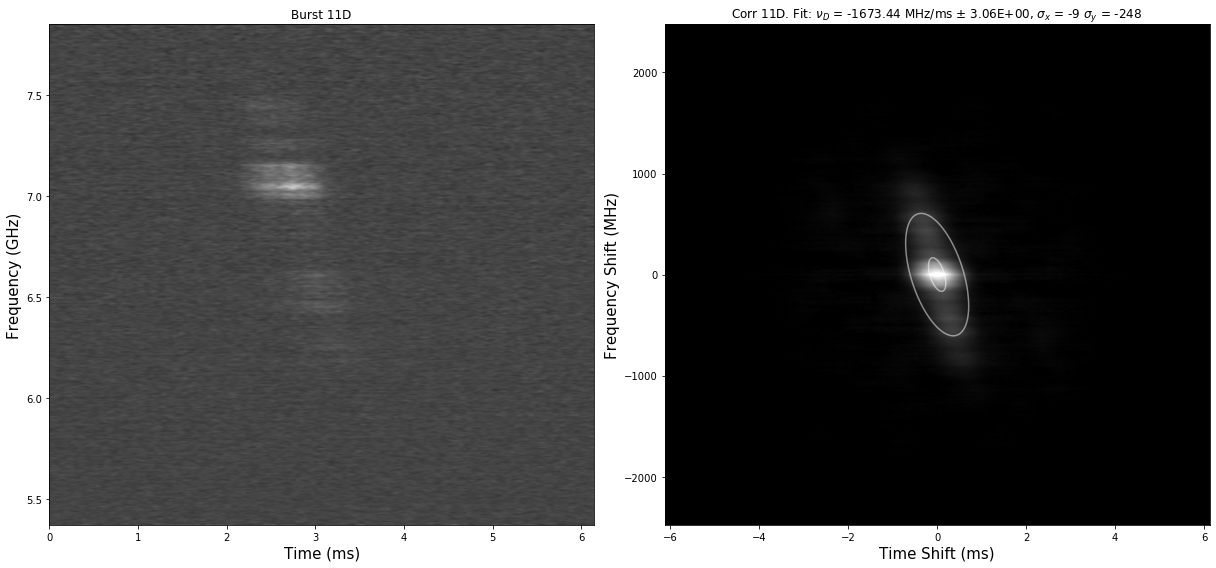

In [88]:
    #### 4. Plot
    cmap = plt.get_cmap('gray')
    cmap.set_bad(color = 'b', alpha = 1.) # potentially hides important errors in the data!

    plt.figure(figsize=(17,8))
    plt.subplot(121)
    plt.title("Burst {}".format(burst))
    
    
    lowestfreq = 6407.7148 - intensity.shape[0]/2*chan_width + chan_width*freqbot # MHz
    print('theta', theta)
    burstextents = [0, 
           time_resolution * burstwindow.shape[1] * 1e3, # time, ms
           lowestfreq * 1e-3, # freq, GHz
           (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
    plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", extent=burstextents)
    # plt.clim(0, np.max(burstwindow))
    plt.xlabel("Time (ms)", size=15)
    plt.ylabel("Frequency (GHz)", size=15)
    # plt.colorbar()

    plt.subplot(122)
    plt.title("Corr {}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, drift, drift_error, popt[3], popt[4]))
    corrextents = [-time_resolution * (corr.shape[1]/2) * 1e3, 
           time_resolution * (corr.shape[1]/2) * 1e3 , 
           - (burstextents[3] - burstextents[2])*1e3, 
           (burstextents[3] - burstextents[2])*1e3]
    print(corrextents)
    plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", extent=corrextents)
    plt.clim(0, np.max(corr)/10)
    
    plt.xlabel("Time Shift (ms)", size=15)
    plt.ylabel("Frequency Shift (MHz)", size=15)
    # plt.colorbar()
    
    plt.contour(fitmap2, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

    plt.tight_layout()
    plt.savefig('{}/burst_{}_figure.png'.format(outfolder, burst))
    print('saved {}/burst_{}_figure.png'.format(outfolder, burst))

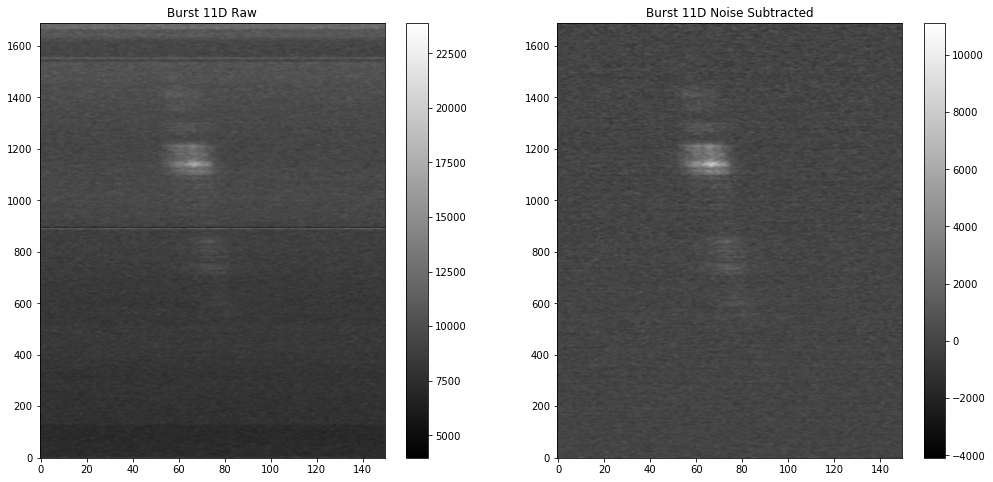

In [90]:
cmap = plt.get_cmap('gray')
# cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
tl,tr = 250,400
plt.figure(figsize=(17,8))

plt.subplot(121)
plt.title("Burst {} Raw".format(burst))
plt.imshow(intensityraw[510:2200,tl:tr], cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
plt.colorbar()

plt.subplot(122)
plt.title("Burst {} Noise Subtracted".format(burst))
# burstextents = [0, 
#        10.24e-6 * burstwindow.shape[-1] * 1e3, 
#        4100.78125 * 1e-3, 
#        (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]
# plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)

freqbot = 510
freqtop = 2200
noise = intensity[freqbot:freqtop,0:40].mean(axis=1)[:, None]
burstwindow = intensity[freqbot:freqtop,tl:tr] - 1*noise
plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
# plt.xlabel("Time (ms)", size=15)
# plt.ylabel("Frequency (GHz)", size=15)
plt.colorbar()
# plt.clim(0, 25000)
plt.savefig('11Dnoise.png')

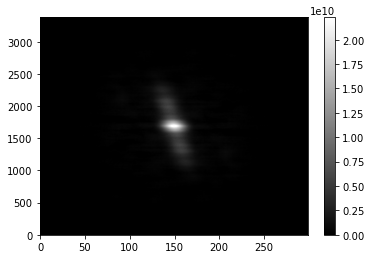

In [28]:
plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower")
plt.clim(0, np.max(corr)/10)
plt.colorbar()